#### MOUNT

In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
# cd /content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training

#### 라이브러리 불러오기

In [30]:
import tensorboard

In [31]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

# 1. 데이터셋 정리(전처리)

In [32]:
dir_data ='./dataset'

In [33]:
## train/test/val 폴더 생성

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

### HGG 파일

In [34]:
# %pwd

In [35]:
import random

dataset_path = './drive/MyDrive/MICCIC_BraTS_2019_Data_Training'
hgg_path = dataset_path + "/HGG"


filename = os.listdir(hgg_path)
fielname = random.shuffle(filename)
filecount = len(filename)
HGG1 = round(filecount*0.8)
HGG2 = round(filecount*0.9)

In [36]:
# !pip install nibabel

In [37]:
import nibabel as nib

In [38]:
if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)
    print('train 생성')

    # train
    train_filenames = filename[:HGG1]

    i=0
    for train_file in train_filenames:
        if train_file[0] == ".":
          continue
        i+=1
        for inner_train_file in os.listdir(hgg_path + "/" + train_file):
            if 'seg' in inner_train_file:
                img_label = nib.load(os.path.join(hgg_path,train_file, inner_train_file)).get_fdata()
                label_3d = np.array(img_label)
                label_ = label_3d[:,:,77]
                np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i),label_)

            #elif 'flair' or 't1' or 't1ce' or 't2' in b
            elif any(sub in inner_train_file for sub in ['flair', 't1', 't1ce', 't2']):
                img_input = nib.load(os.path.join(hgg_path,train_file, inner_train_file)).get_fdata()
                input_3d = np.array(img_input)
                input_ = input_3d[:,:,77]
                np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i),input_)

            else:
                print(f'{train_file}/{inner_train_file} : wrong')

In [39]:
if label_ and input_:
  # ## 이미지 시각화
  plt.subplot(122)
  plt.imshow(label_, cmap='gray')
  plt.title('label')

  plt.subplot(121)
  plt.imshow(input_, cmap='gray')
  plt.title('input')

  plt.show()

In [40]:
if label_ and input_:
  # ## 한 이미지의 분포
  plt.subplot(122)
  plt.hist(label_.flatten(), bins=20)
  plt.title('label')

  plt.subplot(121)
  plt.hist(input_.flatten(), bins=20)
  plt.title('input')

  plt.tight_layout()
  plt.show()

In [41]:
if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)
    print('val 생성')
    # val
    filename_val = filename[HGG1:HGG2]

    i=0
    for train_file in filename_val:
        i+=1
        for inner_train_file in os.listdir(hgg_path + '/' + train_file):
            if 'seg' in inner_train_file:
                img_label = nib.load(os.path.join(hgg_path,train_file, inner_train_file)).get_fdata()
                label_3d = np.array(img_label)
                label_ = label_3d[:,:,77]
                np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i),label_)
            #elif 'flair' or 't1' or 't1ce' or 't2' in b:
            elif any(sub in inner_train_file for sub in ['flair', 't1', 't1ce', 't2']):
                img_input = nib.load(os.path.join(hgg_path,train_file, inner_train_file)).get_fdata()
                input_3d = np.array(img_input)
                input_ = input_3d[:,:,77]
                np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i),input_)
            else:
                print(f'{train_file}/{inner_train_file} : wrong')

In [42]:
if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)
    print('test 생성')

    # test
    filename_test = filename[HGG2:]

    i=0
    for train_file in filename_test:
        i+=1
        for inner_train_file in os.listdir(hgg_path + "/" + train_file):
            if 'seg' in inner_train_file:
                img_label = nib.load(os.path.join(hgg_path,train_file, inner_train_file)).get_fdata()
                label_3d = np.array(img_label)
                label_ = label_3d[:,:,77]
                np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i),label_)
            #elif 'flair' or 't1' or 't1ce' or 't2' in b:
            elif any(sub in inner_train_file for sub in ['flair', 't1', 't1ce', 't2']):
                img_input = nib.load(os.path.join(hgg_path,train_file, inner_train_file)).get_fdata()
                input_3d = np.array(img_label)
                input_ = label_3d[:,:,77]
                np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i),input_)
            else:
                print(f'{train_file}/{inner_train_file} : wrong')

## U-Net 네트워크 구축하기

In [43]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            # nn.Sequential 클래스 : nn.ReLU 등의 모듈들을 인수로 받아서 순서대로 정렬해놓고
            #입력값이 들어오면, 순서대로 묘듈 실행해서 결과값 리턴
            # 리스트 이름에 별 붙여야함

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [44]:
#!pip install segmentation_models_pytorch

In [45]:
import segmentation_models_pytorch as smp

TS_Net = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights="imagenet",
    activation='sigmoid',
    in_channels=1,
    classes=1)

/Users/kim-yuyeon/opt/anaconda3/envs/3dseg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3-1. DataLoader

#### : 네트워크에 데이터를 올리기 위해 DataLoader로 구현

In [46]:
# 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset): #torch.utils.data.Dataset 상속
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        #정렬(오름차순)
        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # 정규화
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 2일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            data = self.transform(data)

        return data

In [47]:
# 데이터로더 잘 구현되었는지 확인
dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

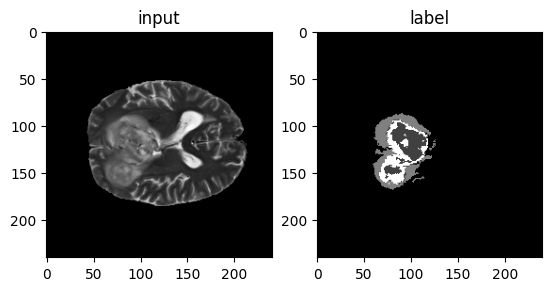

In [48]:
# 불러온 이미지 시각화
plt.subplot(122)
plt.imshow(label.reshape(240,240), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(240,240), cmap='gray')
plt.title('input')

plt.show()

## 3-2.Transform

- ToTensor : numpy에서 tensor로 데이터 type을 변경
- Normalization : 데이터 정규화
- RandomFlip : 랜덤 좌우 및 상하 반전
- ResizeImage : 이미지 사이즈 변경

In [49]:
# 트렌스폼 구현하기
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms


class Grayscale(object):
    def __init__(self, num_output_channels):
        self.num_output_channels = num_output_channels

    def __call__(self, data):
        label, input = data['label'], data['input']

        # 이미지가 흑백이 아닌 경우에만 변환 적용
        if label.shape[0] != 1 and label.shape[0] != 3:
            grayscale_transform = transforms.Grayscale(num_output_channels=self.num_output_channels)
            label = grayscale_transform(label)
            input = grayscale_transform(input)

        data = {'label': label, 'input': input}

        return data

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class ResizeImage:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, data):
        label, input = data['label'], data['input']

        # 이미지 크기 변경
        label = F.interpolate(label.unsqueeze(0), size=self.output_size, mode='bilinear', align_corners=False)
        label = label.squeeze(0)

        input = F.interpolate(input.unsqueeze(0), size=self.output_size, mode='bilinear', align_corners=False)
        input = input.squeeze(0)

        data = {'label': label, 'input': input}

        return data

class MinMaxNormalization(object):
    def __init__(self, min_val=0, max_val=1):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - input.min()) / (input.max() - input.min())
        input = input * (self.max_val - self.min_val) + self.min_val

        data = {'label': label, 'input': input}

        return data


In [50]:
from scipy.ndimage import rotate, gaussian_filter, gaussian_filter1d, map_coordinates        

class FlipRot(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # rotation [0, 45]
        if np.random.rand() > 0.5:
          angle = 45
          label = rotate(label, angle, reshape=False, mode="nearest")
          input = rotate(input, angle, reshape=False, mode="nearest")

        # 수평 뒤집기 
        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

class ElasticTransformation(object):
    def __init__(self, alpha_range, sigma_range):
        self.alpha_range = alpha_range
        self.sigma_range = sigma_range

    def __call__(self, data):
        label, input = data['label'], data['input']

        alpha = np.random.uniform(*self.alpha_range)
        sigma = np.random.uniform(*self.sigma_range)

        random_field = gaussian_filter(np.random.randn(*input.shape), sigma, mode="constant", cval=0) * alpha
        displacement = np.array([gaussian_filter1d(random_field, sigma, axis=i) for i in range(random_field.ndim)])

        label = map_coordinates(label, displacement, order=1, mode='reflect')
        input = map_coordinates(input, displacement, order=3, mode='reflect')

        data = {'label': label, 'input': input}

        return data
    
class GammaCorrection(object):
    def __init__(self, gamma_range):
        self.gamma_range = gamma_range

    def __call__(self, data):
        label, input = data['label'], data['input']

        gamma = np.random.uniform(*self.gamma_range)
        input = input ** gamma

        data = {'label': label, 'input': input}

        return data

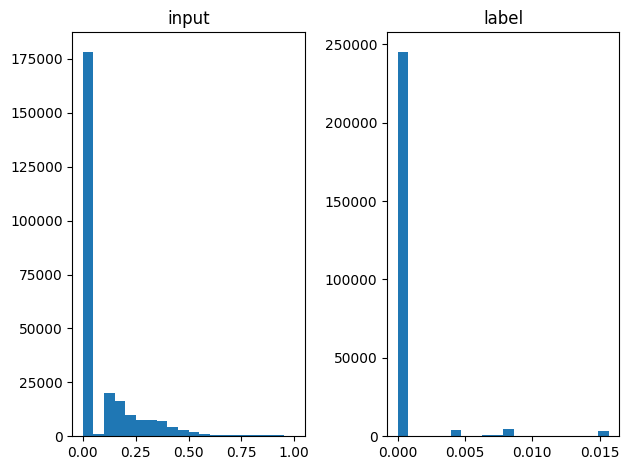

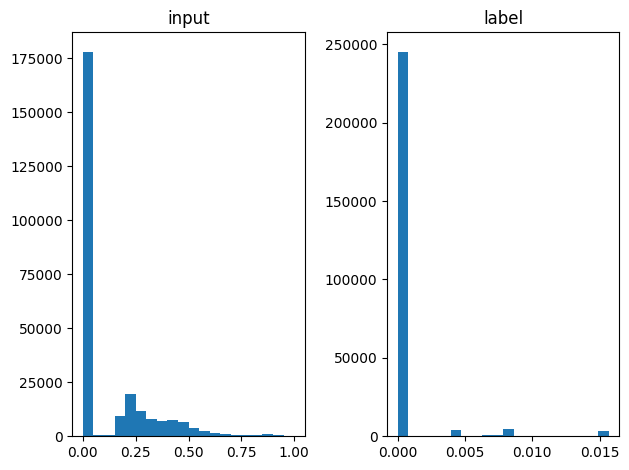

In [51]:
# 트랜스폼 잘 구현되었는지 확인
# transform = transforms.Compose([ToTensor(),
#                                 #Grayscale(num_output_channels=1),
#                                 ResizeImage(output_size=(512,512)),
#                                 MinMaxNormalization()])


# 트랜스폼 잘 구현되었는지 확인
# transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), FlipRot(), ElasticTransformation(alpha_range=(0, 100), sigma_range=(10, 20)), GammaCorrection(gamma_range=(0.4, 1.2)), ToTensor()])
aug = "g"
# transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ElasticTransformation(alpha_range=(0, 100), sigma_range=(10, 20)), ToTensor()])
transform = transforms.Compose([ #ToTensor(),
                                # Normalization(mean=0.5, std=0.5), 
                                ToTensor(),
                                # FlipRot(), 
                                GammaCorrection(gamma_range=(0.4, 1.2)), 
                                ResizeImage(output_size=(512,512)),
                                MinMaxNormalization()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()


dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

1.0 0.0
0.01568627543747425 0.0


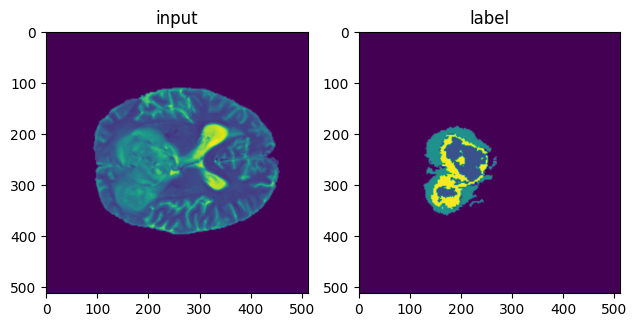

In [52]:
plt.subplot(121)
plt.imshow(input[0,:,:])
plt.title('input')

plt.subplot(122)
plt.imshow(label[0,:,:])
plt.title('label')

print(input[0,:,:].max().item(), input[0,:,:].min().item())
print(label[0,:,:].max().item(), label[0,:,:].min().item())

plt.tight_layout()
plt.show()

In [53]:
label.size()

torch.Size([1, 512, 512])

## 4. 네트워크 저장/불러오는 함수 정의하기

In [54]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

## 5. 네트워크 훈련하기

In [55]:
# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 20
model = "tsnet" # unet, tsnet

base_dir = f'./drive/MyDrive/DACrew/{model}_{lr}_{aug}'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")

num_workers = 0

In [56]:
# 훈련을 위한 Transform과 DataLoader
# transform = transforms.Compose([ToTensor(),
#                                 ResizeImage(output_size=(512,512)),
#                                 MinMaxNormalization()])

transform = transforms.Compose([ #ToTensor(),
                                # Normalization(mean=0.5, std=0.5), 
                                ToTensor(),
                                # FlipRot(), 
                                GammaCorrection(gamma_range=(0.4, 1.2)), 
                                ResizeImage(output_size=(512,512)),
                                MinMaxNormalization()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if model == "unet":
  net = UNet().to(device) 
elif model == "tsnet":
  net = TS_Net.to(device)
# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [57]:
# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [58]:
# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

In [59]:
for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 50마다 모델 저장하기
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()

TRAIN: EPOCH 0001 / 0020 | BATCH 0001 / 0052 | LOSS 0.9791
TRAIN: EPOCH 0001 / 0020 | BATCH 0002 / 0052 | LOSS 0.9622
TRAIN: EPOCH 0001 / 0020 | BATCH 0003 / 0052 | LOSS 0.9434
TRAIN: EPOCH 0001 / 0020 | BATCH 0004 / 0052 | LOSS 0.9269


## 6. 훈련된 모델 테스트하기

In [ ]:
transform = transforms.Compose([ToTensor(),
                                ResizeImage(output_size=(512,512)),
                                MinMaxNormalization()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)
          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

## 7. 결과 시각화하기

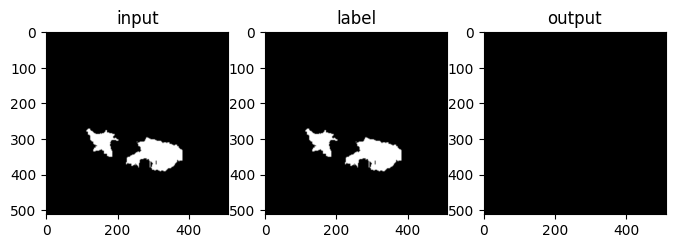

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()
